In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np

import torch
from torchvision import transforms

from models import *
from losses import *

from transformers import Mask2FormerForUniversalSegmentation

from PIL import Image
import cv2

import matplotlib.pyplot as plt

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
model = StyleMatte().to(device)

checkpoint = f'stylematte_pure.pth'
state_dict = torch.load(checkpoint, map_location=device)

model.load_state_dict(state_dict)
model.eval()
print("Model loaded")

Model loaded


In [4]:
model

StyleMatte(
  (fpn): FPN_fuse(
    (conv1x1): ModuleList(
      (0-2): 3 x Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (smooth_conv): ModuleList(
      (0-2): 3 x Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (conv_fusion): Sequential(
      (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (pixel_decoder): Mask2FormerPixelLevelModule(
    (encoder): SwinBackbone(
      (embeddings): SwinEmbeddings(
        (patch_embeddings): SwinPatchEmbeddings(
          (projection): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        )
        (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): SwinEncoder(
        (layers): ModuleList(
          (0): SwinStage(
            (blocks): ModuleList(


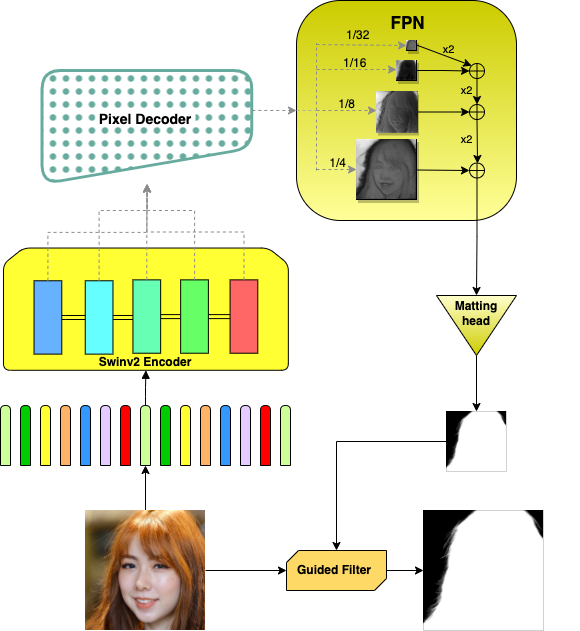

In [5]:
def inference_img(model, img):
    h, w, _ = img.shape
    if h % 8 != 0 or w % 8 != 0:
        img = cv2.copyMakeBorder(img, 8-h % 8, 0, 8-w %
                                 8, 0, cv2.BORDER_REFLECT)

    tensor_img = torch.from_numpy(img).permute(2, 0, 1).cuda()
    input_t = tensor_img
    input_t = input_t/255.0
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    input_t = normalize(input_t)
    input_t = input_t.unsqueeze(0).float()
    with torch.no_grad():
        out = model(input_t)
    result = out[0][:, -h:, -w:].cpu().numpy()

    return result[0]

In [6]:
image = Image.open("photo.jpg").convert("RGB")
image = image.resize((image.size[0]//2, image.size[1]//2))
image = np.array(image)

image.shape

(1824, 2736, 3)

In [7]:
mask = inference_img(model, image)

In [ ]:
mask = np.where(mask >= 0.5, 1, 0)

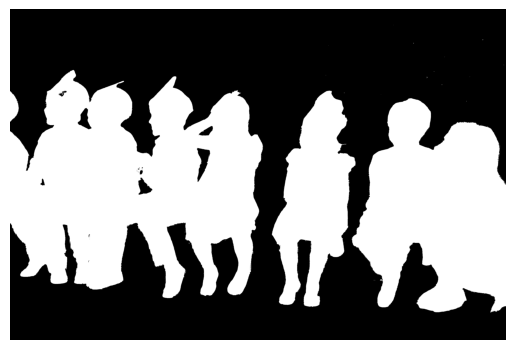

In [20]:
plt.imshow(mask, cmap="gray")
plt.axis("off")
plt.show()

In [15]:
landscape = Image.open("landscape.jpg").convert("RGB")
landscape = landscape.resize((image.shape[1], image.shape[0]))
landscape = np.array(landscape)

In [27]:
new_image = np.where(mask[..., np.newaxis].repeat(3, axis=-1) == 1, image, landscape)

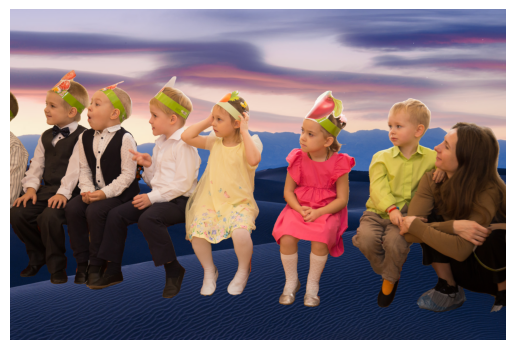

In [29]:
plt.imshow(new_image)
plt.axis("off")
plt.show()